## Introduction
Creating new features from the raw data is one of the best ways to improve your model. For example, you can calculate the number of total projects in the last week and the duration of the fundraising period. The features you create are different for every dataset, so it takes a bit of creativity and experimentation. We're a bit limited here since we're working with only one table. Typically you'll have access to multiple tables with relevant data that you can use to create new features.

But you can still see how to make new features using categorical features, and then a few examples of generated numerical features. Here is the code to load the data and do feature engineering you've already seen.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.preprocessing import LabelEncoder

ks = pd.read_csv('Dataset/kickstarter-projects/ks-projects-201801.csv', parse_dates=['deadline', 'launched'])
# ks.head()

# Drop live projects
ks = ks.query('state != "live"')

# Add outcome column, "successful" == 1, others are 0
ks = ks.assign(outcome=(ks['state'] == 'susccessful').astype(int))

# Timestamp features
ks = ks.assign(hour=ks.launched.dt.hour,
               day=ks.launched.dt.day,
               month=ks.launched.dt.month,
               year=ks.launched.dt.year)

# Label encoding
cat_features = ['category', 'currency', 'country']
encoder = LabelEncoder()
encoded = ks[cat_features].apply(encoder.fit_transform)

data_cols = ['goal', 'hour', 'day', 'month', 'year', 'outcome']
baseline_data = ks[data_cols].join(encoded)

In [2]:
ks.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,outcome,hour,day,month,year
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,0,12,11,8,2015
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00,0,4,2,9,2017
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00,0,0,12,1,2013
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00,0,3,17,3,2012
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00,0,8,4,7,2015


## Interactions
One of the easiest ways to create new features is by combining categorical variables. For example, if one record has the country "CA" and category "Music", you can create a new value "CA_Music". This is a new categorical feature that can provide information about correlations between categorical variables. This type of feature is typically called an interaction. In general, you would build interaction features from all pairs of categorical features. You can make interactions from three or more features as well, but you'll tend to get diminishing returns.

Pandas lets us simply add string columns together like normal Python strings.

In [3]:
interactions = ks['category'] + '_' + ks['country']
print(interactions.head())

0            Poetry_GB
1    Narrative Film_US
2    Narrative Film_US
3             Music_US
4      Film & Video_US
dtype: object


Then, label encode the interaction feature and add it to our data.

In [4]:
label_enc = LabelEncoder()
data_interactions = baseline_data.assign(category_country=label_enc.fit_transform(interactions))
print(data_interactions.head())

      goal  hour  day  month  year  outcome  category  currency  country  \
0   1000.0    12   11      8  2015        0       108         5        9   
1  30000.0     4    2      9  2017        0        93        13       22   
2  45000.0     0   12      1  2013        0        93        13       22   
3   5000.0     3   17      3  2012        0        90        13       22   
4  19500.0     8    4      7  2015        0        55        13       22   

   category_country  
0              1900  
1              1630  
2              1630  
3              1595  
4               979  


In the next exercise, you'll build interaction terms for all pairs of categorical features.

## Number of projects in the last week
First up I'll show you how to count the number of projects launched in the preceeding week for each record. I'll use the .rolling method on a series with the "launched" column as the index. I'll create the series, using ks.launched as the index and ks.index as the values, then sort the times. Using a time series as the index allows us to define the rolling window size in terms of hours, days, weeks, etc.

In [5]:
# First, create a Series with a timestamp index
launched = pd.Series(ks.index, index=ks.launched, name='count_7_days').sort_index()
launched.head(10)

launched
1970-01-01 01:00:00     94579
1970-01-01 01:00:00    319002
1970-01-01 01:00:00    247913
1970-01-01 01:00:00     48147
1970-01-01 01:00:00     75397
1970-01-01 01:00:00      2842
1970-01-01 01:00:00    273779
2009-04-21 21:02:48    169268
2009-04-23 00:07:53    322000
2009-04-24 21:52:03    138572
Name: count_7_days, dtype: int64

There are seven projects that have obviously wrong launch dates, but we'll just ignore them. Again, this is something you'd handle when cleaning the data, but it's not the focus of this mini-course.

With a timeseries index, you can use .rolling to select time periods as the window. For example launched.rolling('7d') creates a rolling window that contains all the data in the previous 7 days. The window contains the current record, so if we want to count all the previous projects but not the current one, we'll need to subtract 1. We'll plot the results to make sure it looks right.

In [6]:
count_7_days = launched.rolling('7d').count() -1
print(count_7_days.head(10))

launched
1970-01-01 01:00:00    0.0
1970-01-01 01:00:00    1.0
1970-01-01 01:00:00    2.0
1970-01-01 01:00:00    3.0
1970-01-01 01:00:00    4.0
1970-01-01 01:00:00    5.0
1970-01-01 01:00:00    6.0
2009-04-21 21:02:48    0.0
2009-04-23 00:07:53    1.0
2009-04-24 21:52:03    2.0
Name: count_7_days, dtype: float64


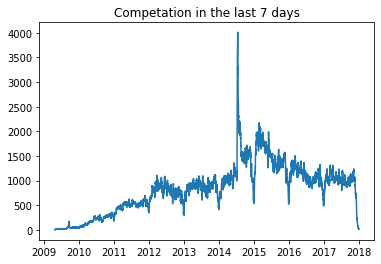

In [7]:
# Ignore records with broken launch dates
plt.plot(count_7_days[7:])
plt.title('Competation in the last 7 days')
plt.show()

Now that we have the counts, we need to adjust the index so we can join it with the other training data.

In [8]:
count_7_days.index = launched.values
count_7_days = count_7_days.reindex(ks.index)

In [9]:
count_7_days.head(10)

0    1409.0
1     957.0
2     739.0
3     907.0
4    1429.0
5    1284.0
6    1119.0
7    1391.0
8    1043.0
9    3199.0
Name: count_7_days, dtype: float64

Now join the new feature with the other data again using .join since we've matched the index.

In [10]:
baseline_data.join(count_7_days).head(10)

,goal,hour,day,month,year,outcome,category,currency,country,count_7_days
0,1000.0,12,11,8,2015,0,108,5,9,1409.0
1,30000.0,4,2,9,2017,0,93,13,22,957.0
2,45000.0,0,12,1,2013,0,93,13,22,739.0
3,5000.0,3,17,3,2012,0,90,13,22,907.0
4,19500.0,8,4,7,2015,0,55,13,22,1429.0
5,50000.0,13,26,2,2016,0,123,13,22,1284.0
6,1000.0,18,1,12,2014,0,58,13,22,1119.0
7,25000.0,20,1,2,2016,0,41,13,22,1391.0
8,125000.0,18,24,4,2014,0,113,13,22,1043.0
9,65000.0,21,11,7,2014,0,39,13,22,3199.0


Time since the last project in the same category
Do projects in the same category compete for donors? If you're trying to fund a video game and another game project was just launched, you might not get as much money. We can capture this by calculating the time since the last launch project in the same category.

A handy method for performing operations within groups is to use .groupby then .transform. The .transform method takes a function then passes a series or dataframe to that function for each group. This returns a dataframe with the same indices as the original dataframe. In our case, we'll perform a groupby on "category" and use transform to calculate the time differences for each category.

In [11]:
def time_since_last_project(series):
    # Return the time in hours
    return series.diff().dt.total_seconds()/3600.

df = ks[['category', 'launched']].sort_values('launched')
timedeltas = df.groupby('category').transform(time_since_last_project)
timedeltas.head(10)

,launched
94579,NaN
319002,NaN
247913,NaN
48147,NaN
75397,NaN
2842,0.0
273779,NaN
169268,NaN
322000,NaN
138572,NaN


We get NaNs here for projects that are the first in their category. We'll need to fill those in with something like the mean or median. We'll also need to reset the index so we can join it with the other data.

In [12]:
# Final time since last project
timedeltas = timedeltas.fillna(timedeltas.median()).reindex(baseline_data.index)
timedeltas.head(10)

,launched
0,18.606111
1,5.592778
2,1.313611
3,0.635000
4,16.661389
5,2.629722
6,0.367500
7,12.286111
8,14.243611
9,0.174722


## Transforming numerical features
The distribution of the values in "goal" shows that most projects have goals less than 5000 USD. However, there is a long tail of goals going up to $100,000. Some models work better when the features are normally distributed, so it might help to transform the goal values. Common choices for this are the square root and natural logarithm. These transformations can also help constrain outliers.

Here I'll transform the goal feature using the square root and log functions, then fit a model to see if it helps

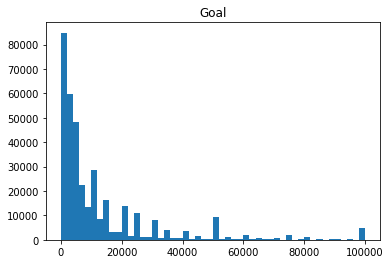

In [13]:
plt.hist(ks.goal, range=(0,100000), bins=50)
plt.title('Goal')
plt.show()

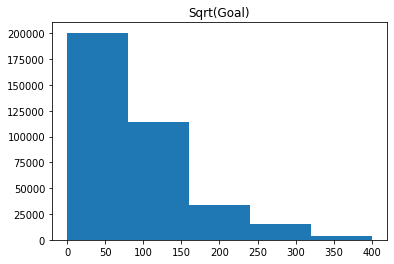

In [14]:
plt.hist(np.sqrt(ks.goal), range=(0,400), bins=5)
plt.title('Sqrt(Goal)')
plt.show()

Text(0.5, 1.0, 'Log(Goal)')

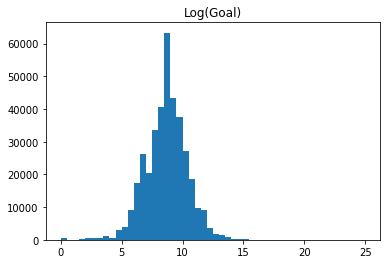

In [15]:
plt.hist(np.log(ks.goal), range=(0, 25), bins=50)
plt.title('Log(Goal)')

The log transformation won't help our model since tree-based models are scale invariant. However, this should help if we had a linear model or neural network.

Other transformations include squares and other powers, exponentials, etc. These might help the model discriminate, like the kernel trick for SVMs. Again, it takes a bit of experimentation to see what works. One method is to create a bunch of new features and later choose the best ones with feature selection algorithms.

## Exercise: Feature Generation
### Introduction

In this set of exercises, you'll create new features from the existing data. Again you'll compare the score lift for each new feature compared to a baseline model. First off, run the cells below to set up a baseline dataset and model.

In [16]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, metrics
import lightgbm as lgb

In [17]:
# Create features from   timestamps
click_data = pd.read_csv('Dataset/train_sample.csv', parse_dates=['click_time'])
click_data.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,89489,3,1,13,379,2017-11-06 15:13:23,NaN,0
1,204158,35,1,13,21,2017-11-06 15:41:07,2017-11-07 08:17:19,1
2,3437,6,1,13,459,2017-11-06 15:42:32,NaN,0
3,167543,3,1,13,379,2017-11-06 15:56:17,NaN,0
4,147509,3,1,13,379,2017-11-06 15:57:01,NaN,0


In [18]:
click_times = click_data['click_time']
clicks = click_data.assign(day=click_times.dt.day.astype('uint8'),
                           hour=click_times.dt.hour.astype('uint8'),
                           minute=click_times.dt.minute.astype('uint8'),
                           second=click_times.dt.second.astype('uint8'))

# Label encoding for categorical features
cat_features = ['ip', 'app', 'device', 'os', 'channel']
for feature in cat_features:
    label_enconder = preprocessing.LabelEncoder()
    clicks[feature] = label_enconder.fit_transform(clicks[feature])

def get_data_splits(dataframe, valid_fraction=0.1):
    dataframe = dataframe.sort_values('click_time')
    valid_rows = int(len(dataframe) * valid_fraction)
    train = dataframe[:-valid_rows * 2]
    # valid size == test size, last two sections of the data
    valid = dataframe[-valid_rows * 2:-valid_rows]
    test = dataframe[-valid_rows:]
    
    return train, valid, test

def train_model(train, valid, test=None, feature_cols=None):
    if feature_cols is None:
        feature_cols = train.columns.drop(['click_time', 'attributed_time', 'is_attributed'])
        
    dtrain = lgb.Dataset(train[feature_cols], label=train['is_attributed'])
    dvalid = lgb.Dataset(train[feature_cols], label=train['is_attributed'])
    
    param = {'num_leaves':64, 'objective':'binary',
             'metric':'auc', 'seed':7}
    num_round = 1000
    
    print('Training Model. Hold on a minute to see the validation score')
    bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], 
                    early_stopping_rounds=20, verbose_eval=False)
    
    valid_pred = bst.predict(valid[feature_cols])
    valid_score = metrics.roc_auc_score(valid['is_attributed'], valid_pred)
    print(f'Validation AUC Score: {valid_score}')
    
    if test is not None:
        test_pred = bst.predict(test[feature_cols])
        test_score = metrics.roc_auc_score(test['is_attributed'], test_pred)
        return bst, valid_score, test_score
    else:
        return bst, valid_score

print('Baseline Model Score')
train, valid, test = get_data_splits(clicks)
_ = train_model(train, valid, test)

Baseline Model Score
Training Model. Hold on a minute to see the validation score
Validation AUC Score: 0.9621117260909214


#### 1) Add interaction features

Here you'll add interaction features for each pair of categorical features (ip, app, device, os, channel). The easiest way to iterate through the pairs of features is with `itertools.combinations`. For each new column, join the values as strings with an underscore, so 13 and 47 would become `"13_47"`. As you add the new columns to the dataset, be sure to label encode the values.

In [19]:
import itertools

cat_featuresatures_features = ['ip', 'app', 'device', 'os', 'channel']
interactions = pd.DataFrame(index=clicks.index)
for col1, col2 in itertools.combinations(cat_features, 2):
    new_col_name = '_'.join([col1,col2])
    
    # Convert to strings and combine
    new_values = clicks[col1].map(str) + '_' + clicks[col2].map(str)
    
    encoder = preprocessing.LabelEncoder()
    interactions[new_col_name] = encoder.fit_transform(new_values)

In [20]:
clicks = clicks.join(interactions)
print('Score with interactions')
train, valid, test = get_data_splits(clicks)
_ = train_model(train, valid)

Score with interactions
Training Model. Hold on a minute to see the validation score
Validation AUC Score: 0.96255676305686


## Generating numerical features

Adding interactions is a quick way to create more categorical features from the data. It's also effective to create new numerical features, you'll typically get a lot of improvement in the model. This takes a bit of brainstorming and experimentation to find features that work well.

For these exercises I'm going to have you implement functions that operate on Pandas Series. It can take multiple minutes to run these functions on the entire data set so instead I'll provide feedback by running your function on a smaller dataset.
### 2) Number of events in the past six hours
The first feature you'll be creating is the number of events from the same IP in the last six hours. It's likely that someone who is visiting often will download the app.

Implement a function count_past_events that takes a Series of click times (timestamps) and returns another Series with the number of events in the last hour. Tip: The rolling method is useful for this.

In [21]:
def count_past_events(series, time_window='6H'):
    series = pd.Series(series.index, index=series)
        # Subtract 1 so the current event isn't counted
    past_events = series.rolling(time_window).count() - 1
    return past_events

Because this can take a while to calculate on the full data, we'll load pre-calculated versions in the cell below to test model performance.